<a href="https://colab.research.google.com/github/COINS-SS21/moody-ser/blob/main/CNN_ResNet18_pp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prerequisites

In [ ]:
!pip install torchlibrosa
!pip install torchaudio
!pip install onnx
!pip install onnxruntime

In [ ]:
import pandas as pd
import numpy as np

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchlibrosa as tlibrosa
from torchlibrosa.stft import DFTBase
import librosa
import torchaudio
import torchvision
from torch.utils.data import Dataset, DataLoader

import onnx
import onnxruntime

import IPython.display as ipd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
ipd.set_matplotlib_formats("retina")

# Set random seed
import random 
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = True

from tqdm.notebook import tqdm
# Register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# Determine PyTorch Device (cuda or cpu)
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

/usr/local/lib/python3.7/dist-packages/tqdm/std.py:658: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Convenience functions for plotting
# Adopted from: https://pytorch.org/tutorials/beginner/audio_preprocessing_tutorial.html
def plot_waveform(waveform, sample_rate, title="Waveform", xlim=None, ylim=None):
  num_frames = len(waveform)
  time_axis = np.arange(0, num_frames) / sample_rate

  figure, axes = plt.subplots(1, 1, figsize=(16, 9))
  axes.set_xlabel("Time [seconds]")
  axes.set_ylabel("Amplitude")
  axes.plot(time_axis, waveform, linewidth=1)
  axes.grid(True)
  if xlim:
    axes.set_xlim(xlim)
  if ylim:
    axes.set_ylim(ylim)
  figure.suptitle(title)
  plt.show(block=False)

def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1, figsize=(16, 9))
  axs.set_title(title or 'Mel Spectrogram (db scaled)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(spec, origin='lower', aspect=aspect, cmap="bwr")
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)

# Data loading

In [ ]:
train_df = pd.concat([
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/train_df.pkl"),
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/noisy_df.pkl"),
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/pitch_df.pkl"),
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/randomly_shifted_df.pkl"),
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/slow_df.pkl"),
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/fast_df.pkl"),
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/left_trimmed_df.pkl"),
    pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/right_trimmed_df.pkl"),
])
test_df = pd.read_pickle("/content/drive/MyDrive/CNN voice emotion recognition/test_df.pkl")

In [ ]:
train_df.head()

,path,emotion,waveform
1242,/content/drive/MyDrive/CNN voice emotion recog...,5,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1660,/content/drive/MyDrive/CNN voice emotion recog...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4149,/content/drive/MyDrive/CNN voice emotion recog...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1191,/content/drive/MyDrive/CNN voice emotion recog...,5,"[0.03646099, 0.04292633, 0.043520577, 0.048239..."
6200,/content/drive/MyDrive/CNN voice emotion recog...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
test_df.head()

,path,emotion,waveform
3226,/content/drive/MyDrive/CNN voice emotion recog...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1503,/content/drive/MyDrive/CNN voice emotion recog...,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4205,/content/drive/MyDrive/CNN voice emotion recog...,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3951,/content/drive/MyDrive/CNN voice emotion recog...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
5347,/content/drive/MyDrive/CNN voice emotion recog...,4,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


# Feature extraction
We use DB scaled mel spectrograms as features for the CNN.

## Conv2d implementation of Short-Time-Fourier-Transform

In [ ]:
# The Conv1d operator is supported by ONNX but not by ONNX.js
# This is the reimplementation of Short-Time-Fourier-Transformation with Conv2d
# Original implementation: https://github.com/qiuqiangkong/torchlibrosa/blob/master/torchlibrosa/stft.py#L155
class STFT(DFTBase):
    def __init__(self, n_fft=2048, hop_length=None, win_length=None,
        window='hann', center=True, pad_mode='reflect', freeze_parameters=True):
        r"""PyTorch implementation of STFT with Conv1d. The function has the 
        same output as librosa.stft.
        Args:
            n_fft: int, fft window size, e.g., 2048
            hop_length: int, hop length samples, e.g., 441
            win_length: int, window length e.g., 2048
            window: str, window function name, e.g., 'hann'
            center: bool
            pad_mode: str, e.g., 'reflect'
            freeze_parameters: bool, set to True to freeze all parameters. Set
                to False to finetune all parameters.
        """
        super(STFT, self).__init__()

        assert pad_mode in ['constant', 'reflect']

        self.n_fft = n_fft
        self.hop_length = hop_length
        self.win_length = win_length
        self.window = window
        self.center = center
        self.pad_mode = pad_mode

        # By default, use the entire frame.
        if self.win_length is None:
            self.win_length = n_fft

        # Set the default hop, if it's not already specified.
        if self.hop_length is None:
            self.hop_length = int(self.win_length // 4)

        fft_window = librosa.filters.get_window(window, self.win_length, fftbins=True)

        # Pad the window out to n_fft size.
        fft_window = librosa.util.pad_center(fft_window, n_fft)

        # DFT & IDFT matrix.
        self.W = self.dft_matrix(n_fft)

        out_channels = n_fft // 2 + 1

        self.conv_real = nn.Conv2d(in_channels=1, out_channels=out_channels,
            kernel_size=(1, n_fft), stride=self.hop_length, padding=0, dilation=1,
            groups=1, bias=False)

        self.conv_imag = nn.Conv2d(in_channels=1, out_channels=out_channels,
            kernel_size=(1, n_fft), stride=self.hop_length, padding=0, dilation=1,
            groups=1, bias=False)

        # Initialize Conv2d weights.
        self.conv_real.weight.data = torch.unsqueeze(torch.Tensor(
            np.real(self.W[:, 0 : out_channels] * fft_window[:, None]).T), dim=1)[:, None, :]
        # (n_fft // 2 + 1, 1, 1, n_fft)

        self.conv_imag.weight.data = torch.unsqueeze(torch.Tensor(
            np.imag(self.W[:, 0 : out_channels] * fft_window[:, None]).T), dim=1)[:, None, :]
        # (n_fft // 2 + 1, 1, 1, n_fft)

        if freeze_parameters:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, input):
        r"""Calculate STFT of batch of signals.
        Args: 
            input: (batch_size, data_length), input signals.
        Returns:
            real: (batch_size, 1, time_steps, n_fft // 2 + 1)
            imag: (batch_size, 1, time_steps, n_fft // 2 + 1)
        """

        x = torch.unsqueeze(input, dim=1)  # (batch_size, channels_num, data_length)

        if self.center:
            x = F.pad(x, pad=(self.n_fft // 2, self.n_fft // 2), mode=self.pad_mode)

        # Another unsqueeze because we are using Conv2d now and not Conv1d
        x = torch.unsqueeze(x, dim=1) # (batch_size, 1, channels_num, data_length)

        real = self.conv_real(x)
        imag = self.conv_imag(x)
        # (batch_size, 1, n_fft // 2 + 1, time_steps)

        real = real.transpose(1, 2).transpose(2, 3)
        imag = imag.transpose(1, 2).transpose(2, 3)
        # (batch_size, 1, time_steps, n_fft // 2 + 1)

        return real, imag
        
tlibrosa.stft.STFT = STFT

## Visualization for one example

In [ ]:
sample_rate = 22050
waveform = train_df.sample().iloc[0]["waveform"]
waveform = torch.unsqueeze(torch.tensor(waveform, dtype=torch.float), 0)

Sample rate: 22050


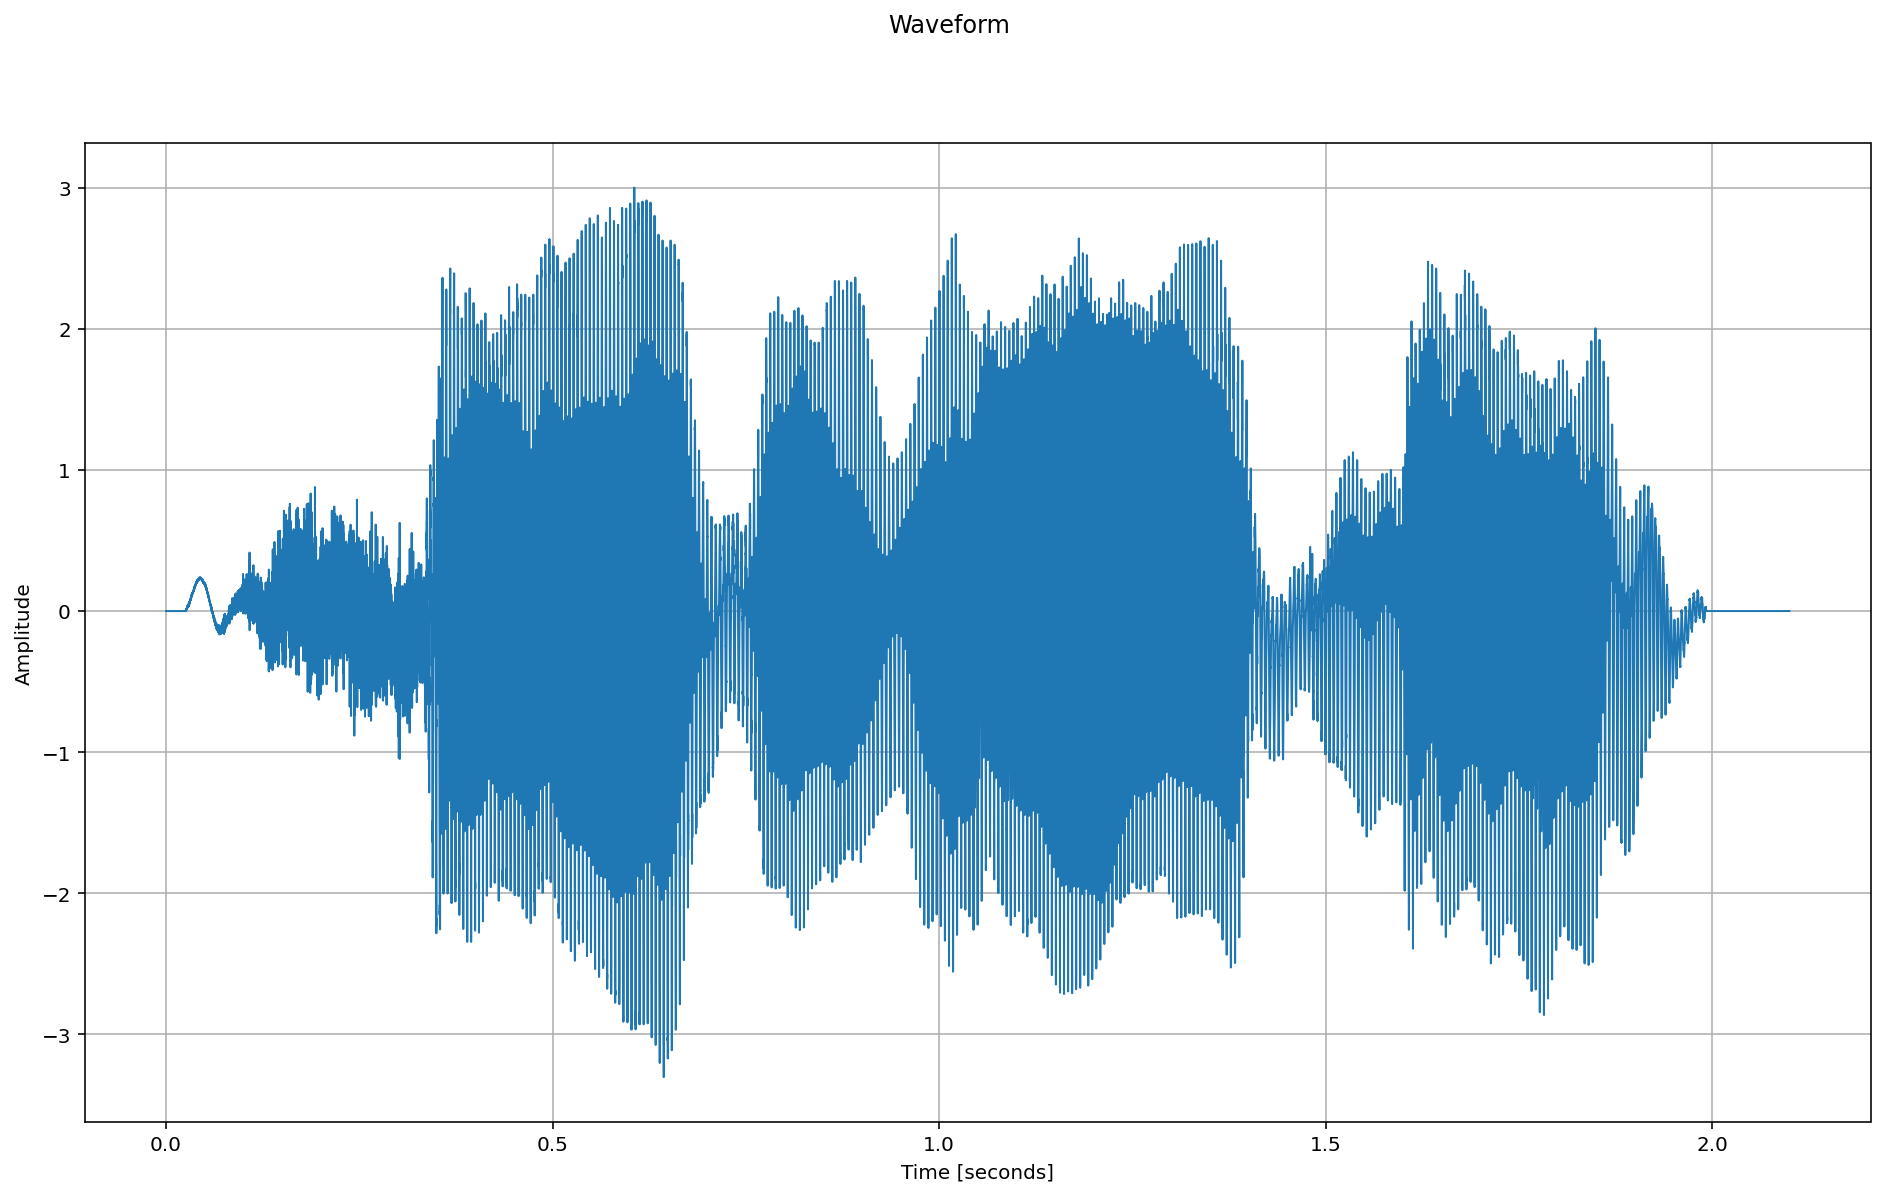

In [ ]:
print("Sample rate:", sample_rate)
plot_waveform(waveform[0], sample_rate)

In [ ]:
# This melspec_extractor makes use of our own ONNX.js compatible version of the STFT class using Conv2d layers
melspec_extractor = nn.Sequential(
    tlibrosa.Spectrogram(
        hop_length=512,
        win_length=2048
    ), 
    tlibrosa.LogmelFilterBank(
        sr=sample_rate,
        n_mels=128,
        is_log=False, # log10 is not supported by ONNX
    ))

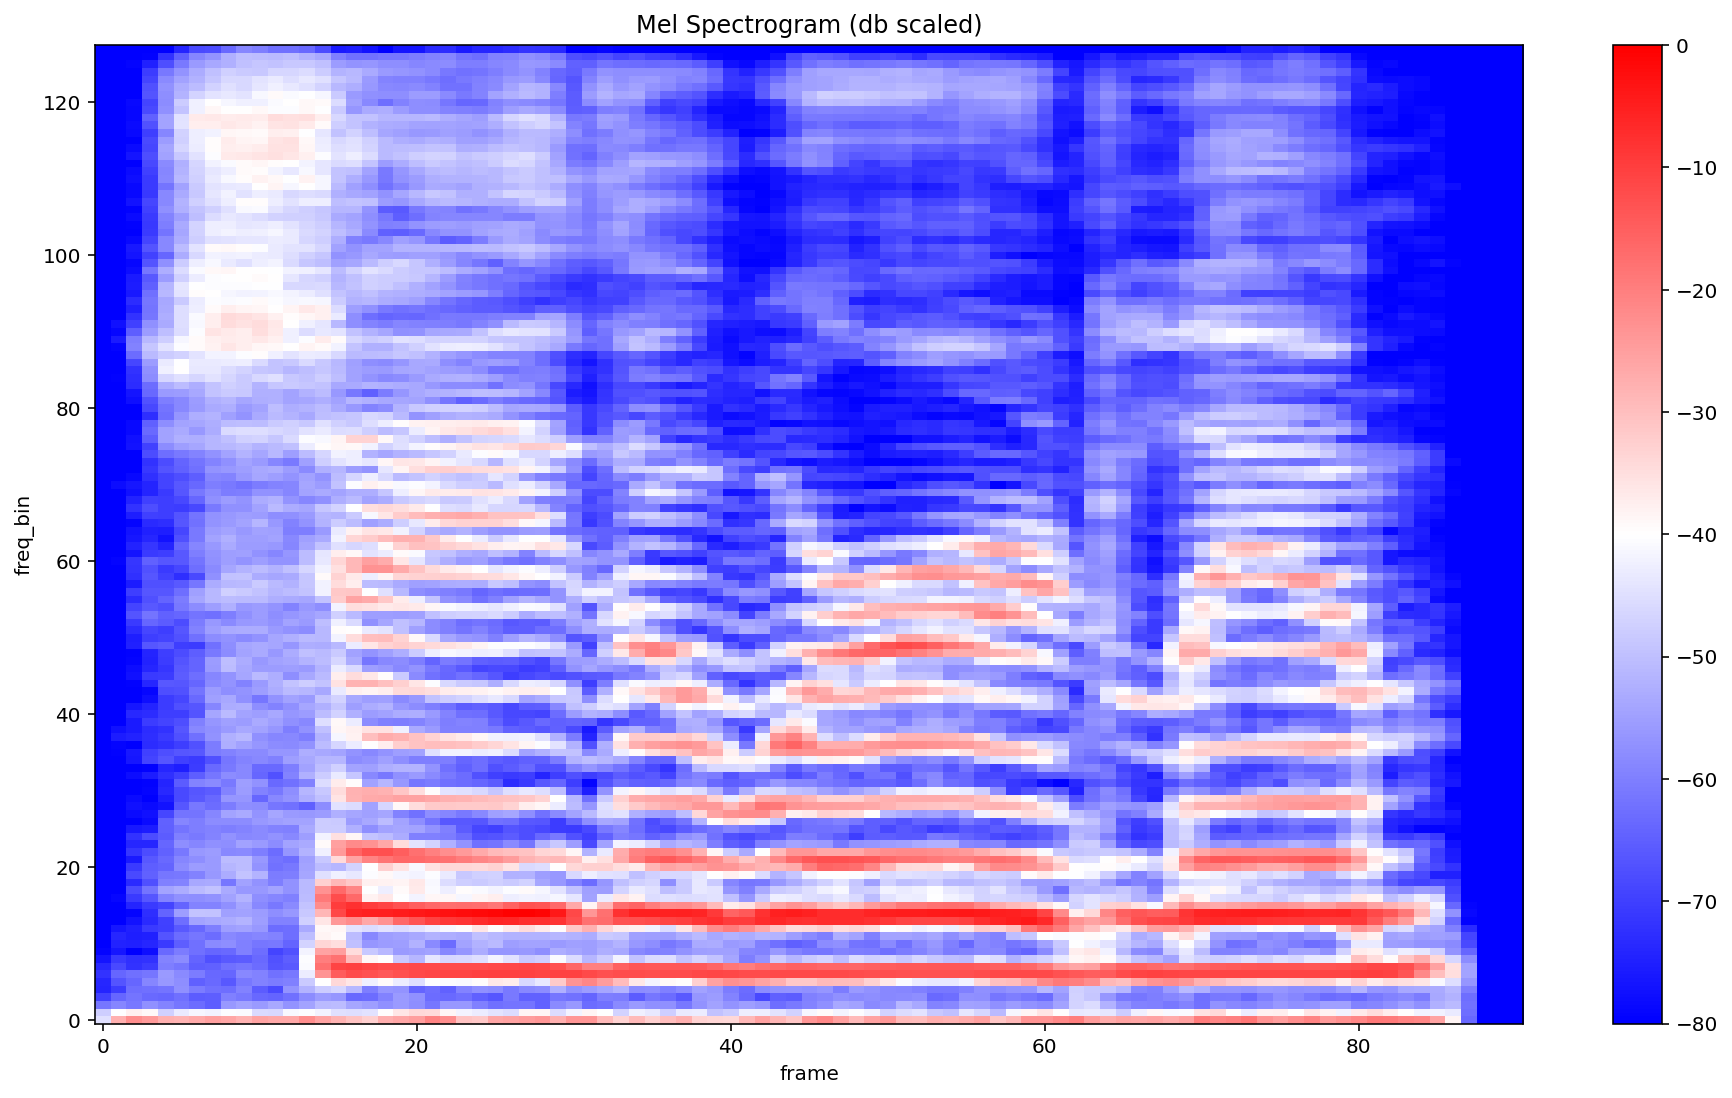

In [ ]:
# Extract the mel spectrogram with torchlibrosa and our own Conv2d STFT
melspec = melspec_extractor(waveform)
# This is the librosa.power_to_db function implemented with torch operations
log_melspec = 10.0 * torch.log(torch.clamp(melspec, min=1e-10)) / torch.log(torch.tensor(10.0))
log_melspec -= 10.0 * torch.log(torch.max(torch.tensor(1e-10), melspec.max())) / torch.log(torch.tensor(10.0))
log_melspec = torch.max(log_melspec, log_melspec.max() - torch.tensor(80.0))

plot_spectrogram(log_melspec[0][0].transpose(1, 0))

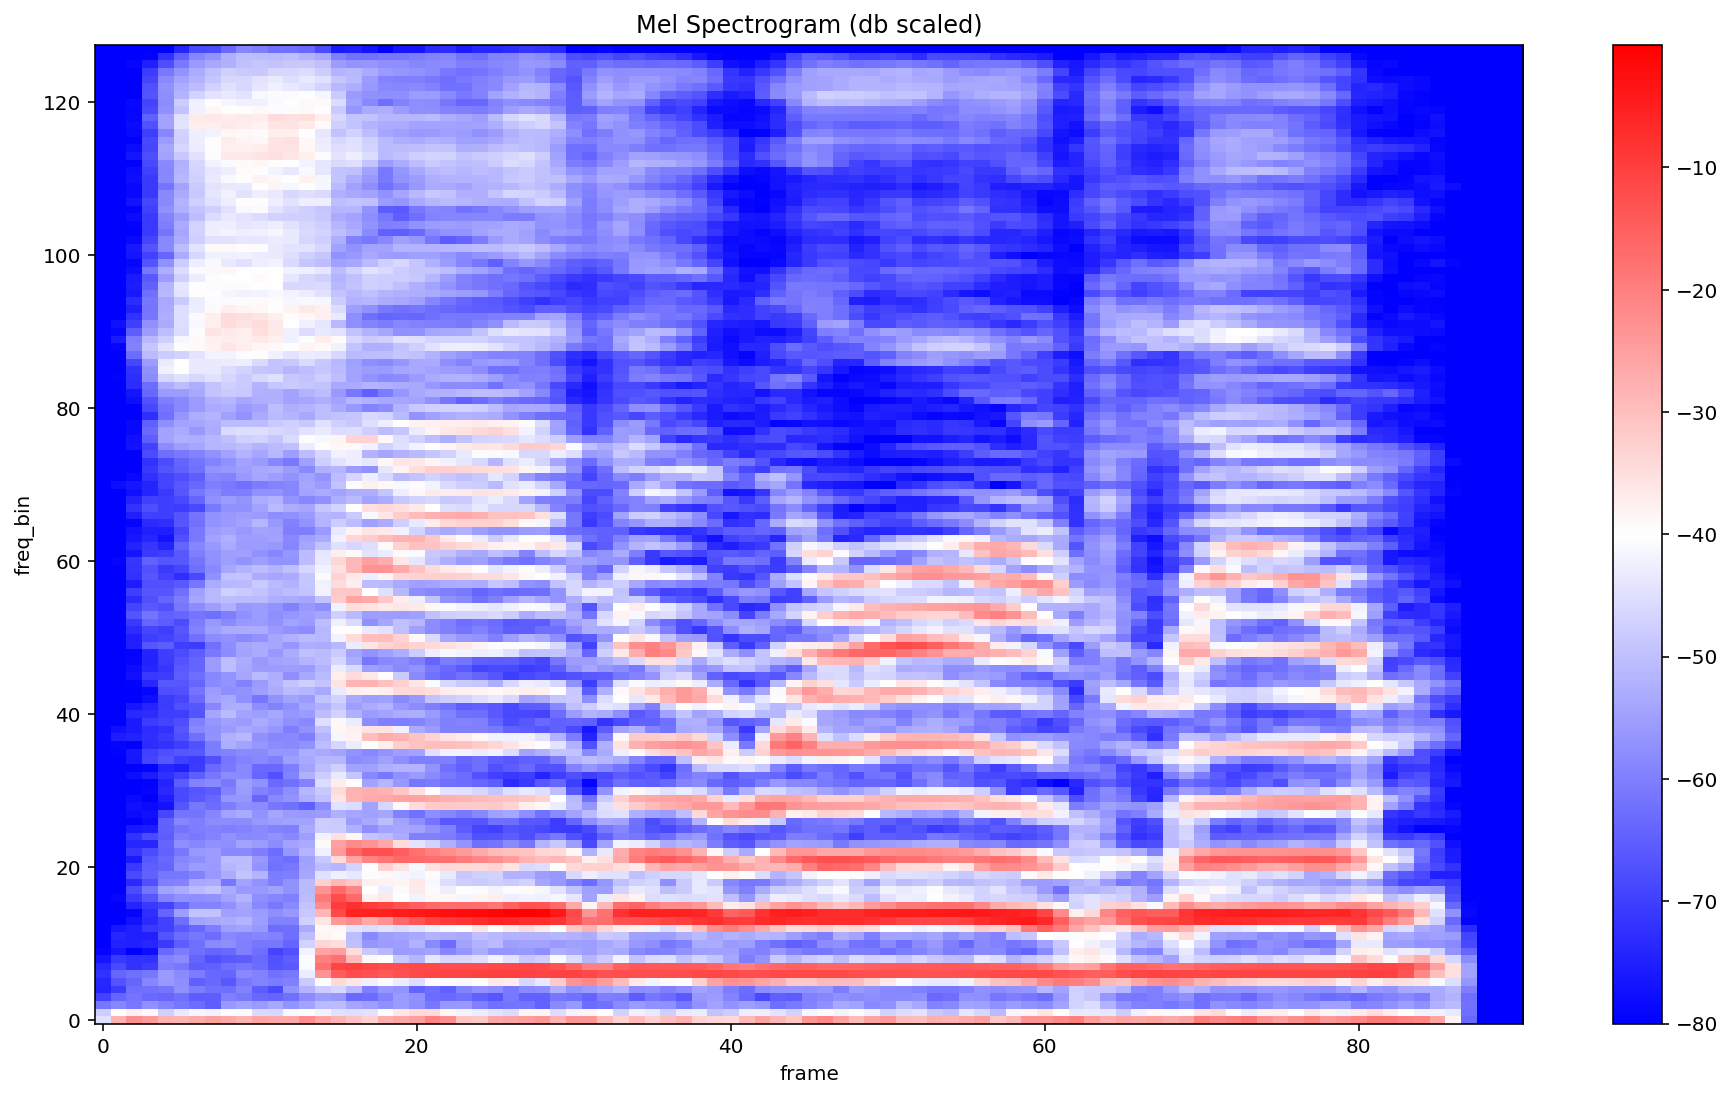

In [ ]:
# Compare the result to librosa
plot_spectrogram(librosa.power_to_db(librosa.feature.melspectrogram(y=waveform.cpu().numpy()[0], sr=sample_rate, n_mels=128, hop_length=512, win_length=2048), ref=np.max))

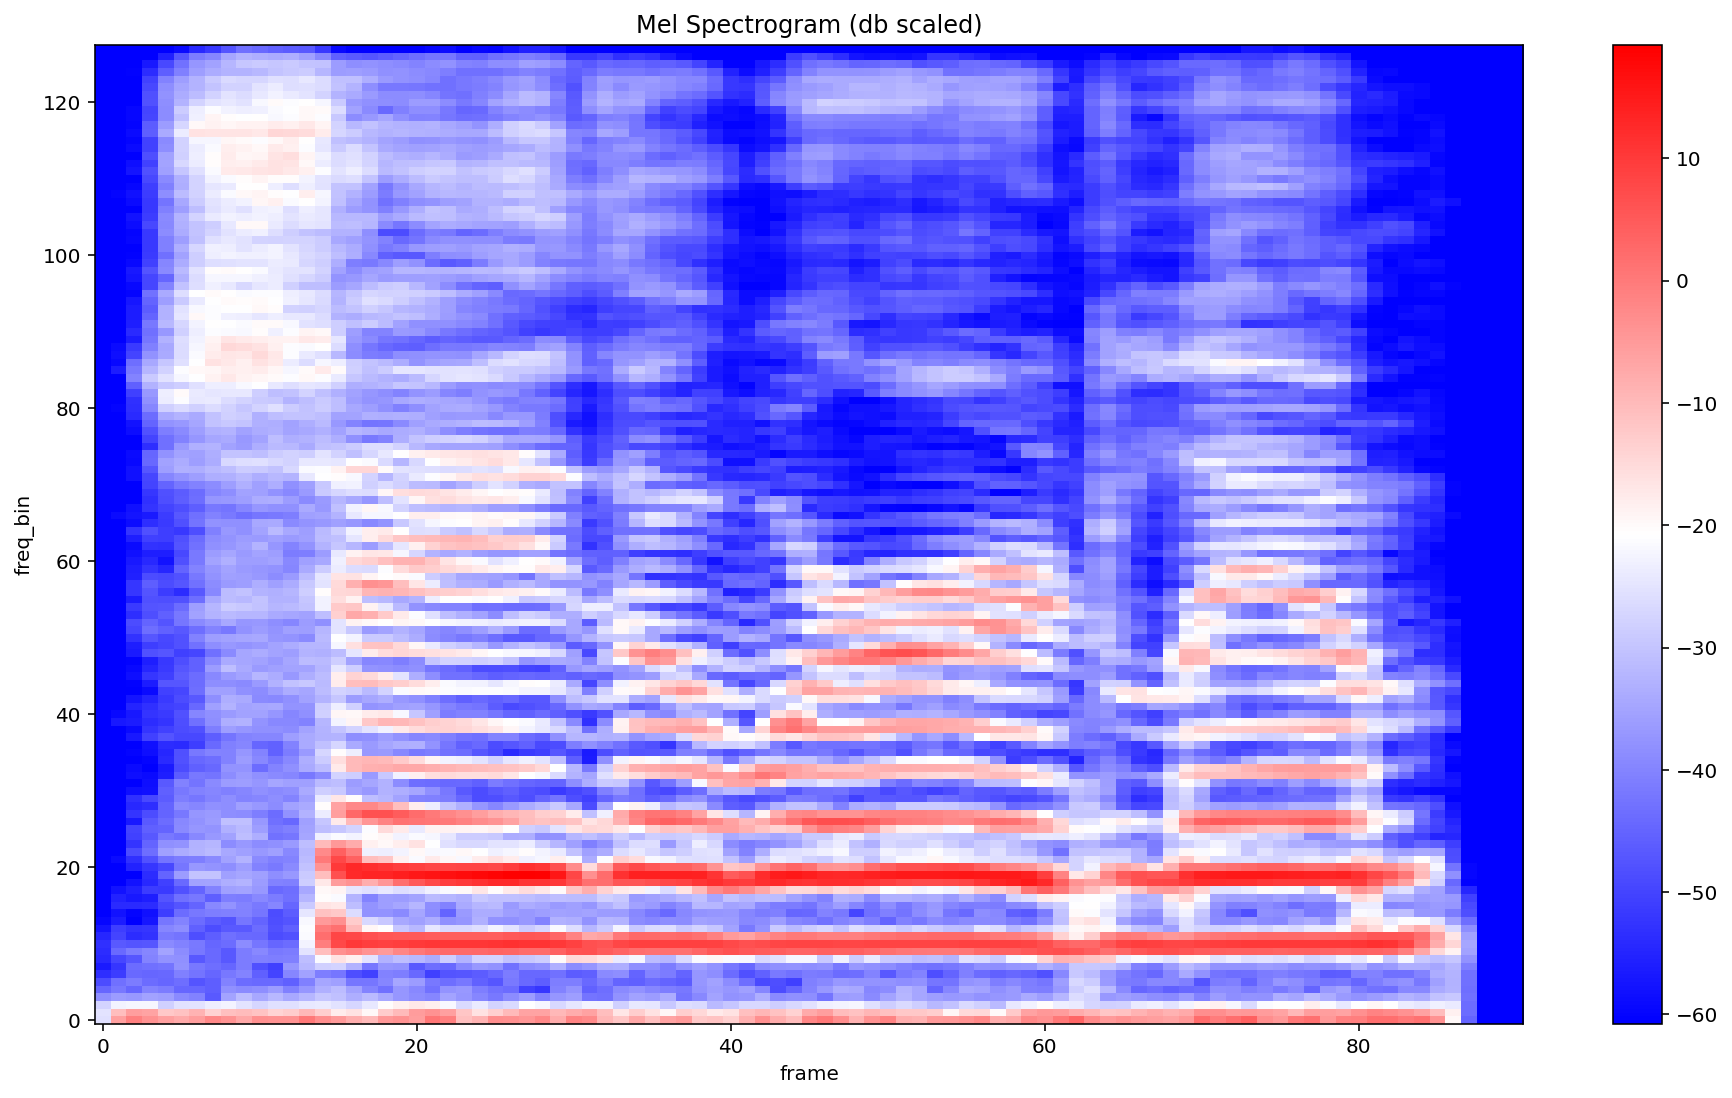

In [ ]:
# Compare the result to torchaudio (slightly different than the two others)
ta_melspec_extractor = nn.Sequential(
    torchaudio.transforms.MelSpectrogram(sample_rate=sample_rate, n_fft=2048, hop_length=512, normalized=True, n_mels=128, norm="slaney", win_length=2048, center=True),
    torchaudio.transforms.AmplitudeToDB(top_db=80))

plot_spectrogram(ta_melspec_extractor(waveform[0]))

# PyTorch CNN

In [ ]:
class VoiceEmotionDataset(Dataset):
  def __init__(self, X: np.ndarray, y: np.ndarray):
    self.X = X
    self.y = y

  def __len__(self):
    return len(self.y)
  
  def __getitem__(self, index):
    return (
        torch.tensor(self.X[index], device=DEVICE, dtype=torch.float),
        torch.tensor(self.y[index], device=DEVICE, dtype=torch.long)
    )

In [ ]:
train_ds = VoiceEmotionDataset(train_df["waveform"].values, train_df["emotion"].values)
test_ds = VoiceEmotionDataset(test_df["waveform"].values, test_df["emotion"].values)

In [ ]:
train_dl = DataLoader(train_ds, batch_size=64, shuffle=True)
test_dl = DataLoader(test_ds, batch_size=64)

In [ ]:
class VoiceEmotionCnn(nn.Module):
    def __init__(self):
      super().__init__()

      self.melspec_extractor = nn.Sequential(
          tlibrosa.Spectrogram(
              hop_length=512,
              win_length=2048,
              freeze_parameters=True
          ),
          tlibrosa.LogmelFilterBank(
              sr=22050,
              n_mels=128,
              is_log=False, # log10 operation is not supported by ONNX, this is worked-around in the forward-pass
              freeze_parameters=True
          ),
      )

      self.resnet18 = torchvision.models.resnet18(pretrained=False)
      # We have only 1 input channel and therefore replace the default input layer of resnet18
      self.resnet18.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

      # Replace the default classifier with our classifier
      # We have 8 output nodes because the RAVDESS dataset has 8 different emotions to predict
      self.resnet18.fc = nn.Sequential(
          nn.Dropout(p=0.5),
          nn.Linear(512, 256),
          nn.ReLU(),
          nn.Dropout(p=0.5),
          nn.LayerNorm(256),
          nn.Linear(256, 8),
        )
        
    def forward(self, X):
      # Extract the melspectrogram
      melspec = self.melspec_extractor(X).transpose(3, 2)

      # Transform it to a logarithmic decibel-scaled spectrogram
      # Since log10 is not supported in onnx we use log(...) / log(10)
      # This implementation is the same as librosa.power_to_db with kwargs
      # ref=torch.max, amin=1e-10, top_db=80.0
      # https://librosa.org/doc/latest/_modules/librosa/core/spectrum.html#power_to_db
      log_melspec = 10.0 * torch.log(torch.clamp(melspec, min=1e-10)) / torch.log(torch.tensor(10.0))
      log_melspec -= 10.0 * torch.log(torch.max(torch.tensor(1e-10), melspec.max())) / torch.log(torch.tensor(10.0))
      log_melspec = torch.max(log_melspec, log_melspec.max() - torch.tensor(80.0))
      
      # The log-melspectrogram is now the input for the convolutional part
      X = log_melspec
    
      # Get the logits returned by our modified resnet18
      logits = self.resnet18(X)
      return logits

In [ ]:
voice_emotion_cnn = VoiceEmotionCnn().to(DEVICE)
voice_emotion_cnn

VoiceEmotionCnn(
  (melspec_extractor): Sequential(
    (0): Spectrogram(
      (stft): STFT(
        (conv_real): Conv2d(1, 1025, kernel_size=(1, 2048), stride=(512, 512), bias=False)
        (conv_imag): Conv2d(1, 1025, kernel_size=(1, 2048), stride=(512, 512), bias=False)
      )
    )
    (1): LogmelFilterBank()
  )
  (resnet18): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1

In [ ]:
epochs = 50
lr = 1e-3
optimizer = torch.optim.SGD(voice_emotion_cnn.parameters(), lr=lr, weight_decay=1e-2, momentum=0.9)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=15, verbose=True)
loss_func = nn.CrossEntropyLoss()

In [ ]:
def accuracy(logits, yb):
    preds = torch.argmax(logits, dim=1)
    return (preds == yb).float().mean()

In [ ]:
# This epoch will overwrite the calculated best model saving
manual_checkpoint = 6
accs = []
accs_test = []
losses = []
losses_test = []
best_loss_test = np.inf
best_epoch = 0
def train(net, train_dl, test_dl, epochs, optimizer, loss_func):
  global best_loss_test
  global best_epoch

  for epoch in range(epochs):
    # Training
    net.train()
    total_acc = 0
    total_loss = 0

    for xb, yb in tqdm(train_dl):
      xb = xb.to(DEVICE)
      yb = yb.to(DEVICE)

      preds = net(xb)

      loss = loss_func(preds, yb)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      with torch.no_grad():
        net.eval()
        total_loss += loss
        total_acc += accuracy(preds, yb)
    
    total_loss /= len(train_dl)
    losses.append(total_loss)
    total_acc /= len(train_dl)
    accs.append(total_acc)

    # Validation
    net.eval()
    total_acc_test = 0
    total_loss_test = 0

    with torch.no_grad():
      for xb_test, yb_test in test_dl:
        xb_test = xb_test.to(DEVICE)
        yb_test = yb_test.to(DEVICE)

        preds_test = net(xb_test)

        loss_test = loss_func(preds_test, yb_test)

        total_loss_test += loss_test
        total_acc_test += accuracy(preds_test, yb_test)
      
    total_acc_test /= len(test_dl)
    accs_test.append(total_acc_test)
    total_loss_test /= len(test_dl)
    losses_test.append(total_loss_test)
    
    if not manual_checkpoint:
      # Always save the best model (best test loss)
      if total_loss_test < best_loss_test:
        print(f"New best model found in epoch {epoch:d}. Saving to drive ...")
        torch.save(net.state_dict(), "/content/drive/MyDrive/CNN voice emotion recognition/saved_models/voice_emotion_cnn_resnet_parameters.pth")
        best_epoch = epoch
        best_loss_test = total_loss_test
    elif epoch == manual_checkpoint:
        print(f"Manual checkpoint found in epoch {epoch:d}. Saving to drive ...")
        torch.save(net.state_dict(), "/content/drive/MyDrive/CNN voice emotion recognition/saved_models/voice_emotion_cnn_resnet_parameters.pth")
    else:
      if total_loss_test < best_loss_test:
        print(f"New best model found in epoch {epoch:d}. Not saving because manual checkpoint is set.")
        best_epoch = epoch
        best_loss_test = total_loss_test

    # Update learning rate scheduler
    lr_scheduler.step(total_loss_test)

    print("----------------------------------------------------------------------------------------------------")
    print("epoch\t| loss\t\t| accuracy\t| loss_test\t| accuracy_test")
    print(f"{epoch:d}\t| {total_loss:.4f}\t| {total_acc:.4f}\t| {total_loss_test:.4f}\t| {total_acc_test:.4f}")

In [ ]:
%%time
train(voice_emotion_cnn, train_dl, test_dl, epochs, optimizer, loss_func)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)



New best model found in epoch 0. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
0	| 1.7647	| 0.2684	| 1.2017	| 0.5362



New best model found in epoch 1. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
1	| 1.0279	| 0.6122	| 0.7032	| 0.7369



New best model found in epoch 2. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
2	| 0.6599	| 0.7562	| 0.5168	| 0.8107



New best model found in epoch 3. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
3	| 0.4970	| 0.8204	| 0.4807	| 0.8222



New best model found in epoch 4. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
4	| 0.3764	| 0.8680	| 0.4429	| 0.8488



New best model found in epoch 5. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
5	| 0.3039	| 0.8961	| 0.4062	| 0.8525



Manual checkpoint found in epoch 6. Saving to drive ...
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
6	| 0.2521	| 0.9143	| 0.3520	| 0.8785



New best model found in epoch 7. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
7	| 0.2125	| 0.9292	| 0.3968	| 0.8665



New best model found in epoch 8. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
8	| 0.2008	| 0.9333	| 0.3811	| 0.8613



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
9	| 0.1982	| 0.9334	| 0.3860	| 0.8692



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
10	| 0.1574	| 0.9491	| 0.4548	| 0.8494



New best model found in epoch 11. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
11	| 0.1553	| 0.9502	| 0.3742	| 0.8816



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
12	| 0.1635	| 0.9475	| 0.3809	| 0.8727



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
13	| 0.1634	| 0.9457	| 0.4541	| 0.8462



New best model found in epoch 14. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
14	| 0.1534	| 0.9491	| 0.3107	| 0.8926



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
15	| 0.1325	| 0.9578	| 0.3288	| 0.8941



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
16	| 0.1432	| 0.9529	| 0.3576	| 0.8790



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
17	| 0.1336	| 0.9584	| 0.3501	| 0.8879



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
18	| 0.1144	| 0.9662	| 0.3866	| 0.8796



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
19	| 0.1279	| 0.9606	| 0.3558	| 0.8947



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
20	| 0.1221	| 0.9633	| 0.4411	| 0.8509



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
21	| 0.1317	| 0.9599	| 0.3676	| 0.8785



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
22	| 0.1307	| 0.9580	| 0.3462	| 0.8905



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
23	| 0.1131	| 0.9662	| 0.3402	| 0.8905



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
24	| 0.1241	| 0.9624	| 0.4669	| 0.8436



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
25	| 0.1121	| 0.9659	| 0.3888	| 0.8718



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
26	| 0.1188	| 0.9646	| 0.3552	| 0.8884



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
27	| 0.1153	| 0.9652	| 0.5092	| 0.8436



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
28	| 0.1195	| 0.9634	| 0.4621	| 0.8472



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
29	| 0.1053	| 0.9695	| 0.3742	| 0.8863



Epoch    31: reducing learning rate of group 0 to 1.0000e-04.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
30	| 0.1162	| 0.9649	| 0.4126	| 0.8733



New best model found in epoch 31. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
31	| 0.0345	| 0.9945	| 0.2961	| 0.9155



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
32	| 0.0289	| 0.9965	| 0.2965	| 0.9124



New best model found in epoch 33. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
33	| 0.0276	| 0.9973	| 0.2953	| 0.9134



New best model found in epoch 34. Not saving because manual checkpoint is set.
----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
34	| 0.0267	| 0.9973	| 0.2929	| 0.9155



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
35	| 0.0261	| 0.9978	| 0.3022	| 0.9119



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
36	| 0.0259	| 0.9975	| 0.3046	| 0.9119



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
37	| 0.0252	| 0.9976	| 0.3096	| 0.9092



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
38	| 0.0256	| 0.9975	| 0.3046	| 0.9108



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
39	| 0.0252	| 0.9974	| 0.3082	| 0.9066



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
40	| 0.0248	| 0.9981	| 0.3141	| 0.9098



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
41	| 0.0243	| 0.9980	| 0.3109	| 0.9087



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
42	| 0.0243	| 0.9977	| 0.3137	| 0.9050



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
43	| 0.0241	| 0.9977	| 0.3158	| 0.9061



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
44	| 0.0238	| 0.9979	| 0.3277	| 0.9045



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
45	| 0.0244	| 0.9979	| 0.3370	| 0.9040



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
46	| 0.0236	| 0.9978	| 0.3326	| 0.9050



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
47	| 0.0238	| 0.9978	| 0.3475	| 0.8998



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
48	| 0.0234	| 0.9978	| 0.3389	| 0.9024



----------------------------------------------------------------------------------------------------
epoch	| loss		| accuracy	| loss_test	| accuracy_test
49	| 0.0225	| 0.9979	| 0.3338	| 0.9056
CPU times: user 25min 7s, sys: 13.8 s, total: 25min 21s
Wall time: 21min 51s


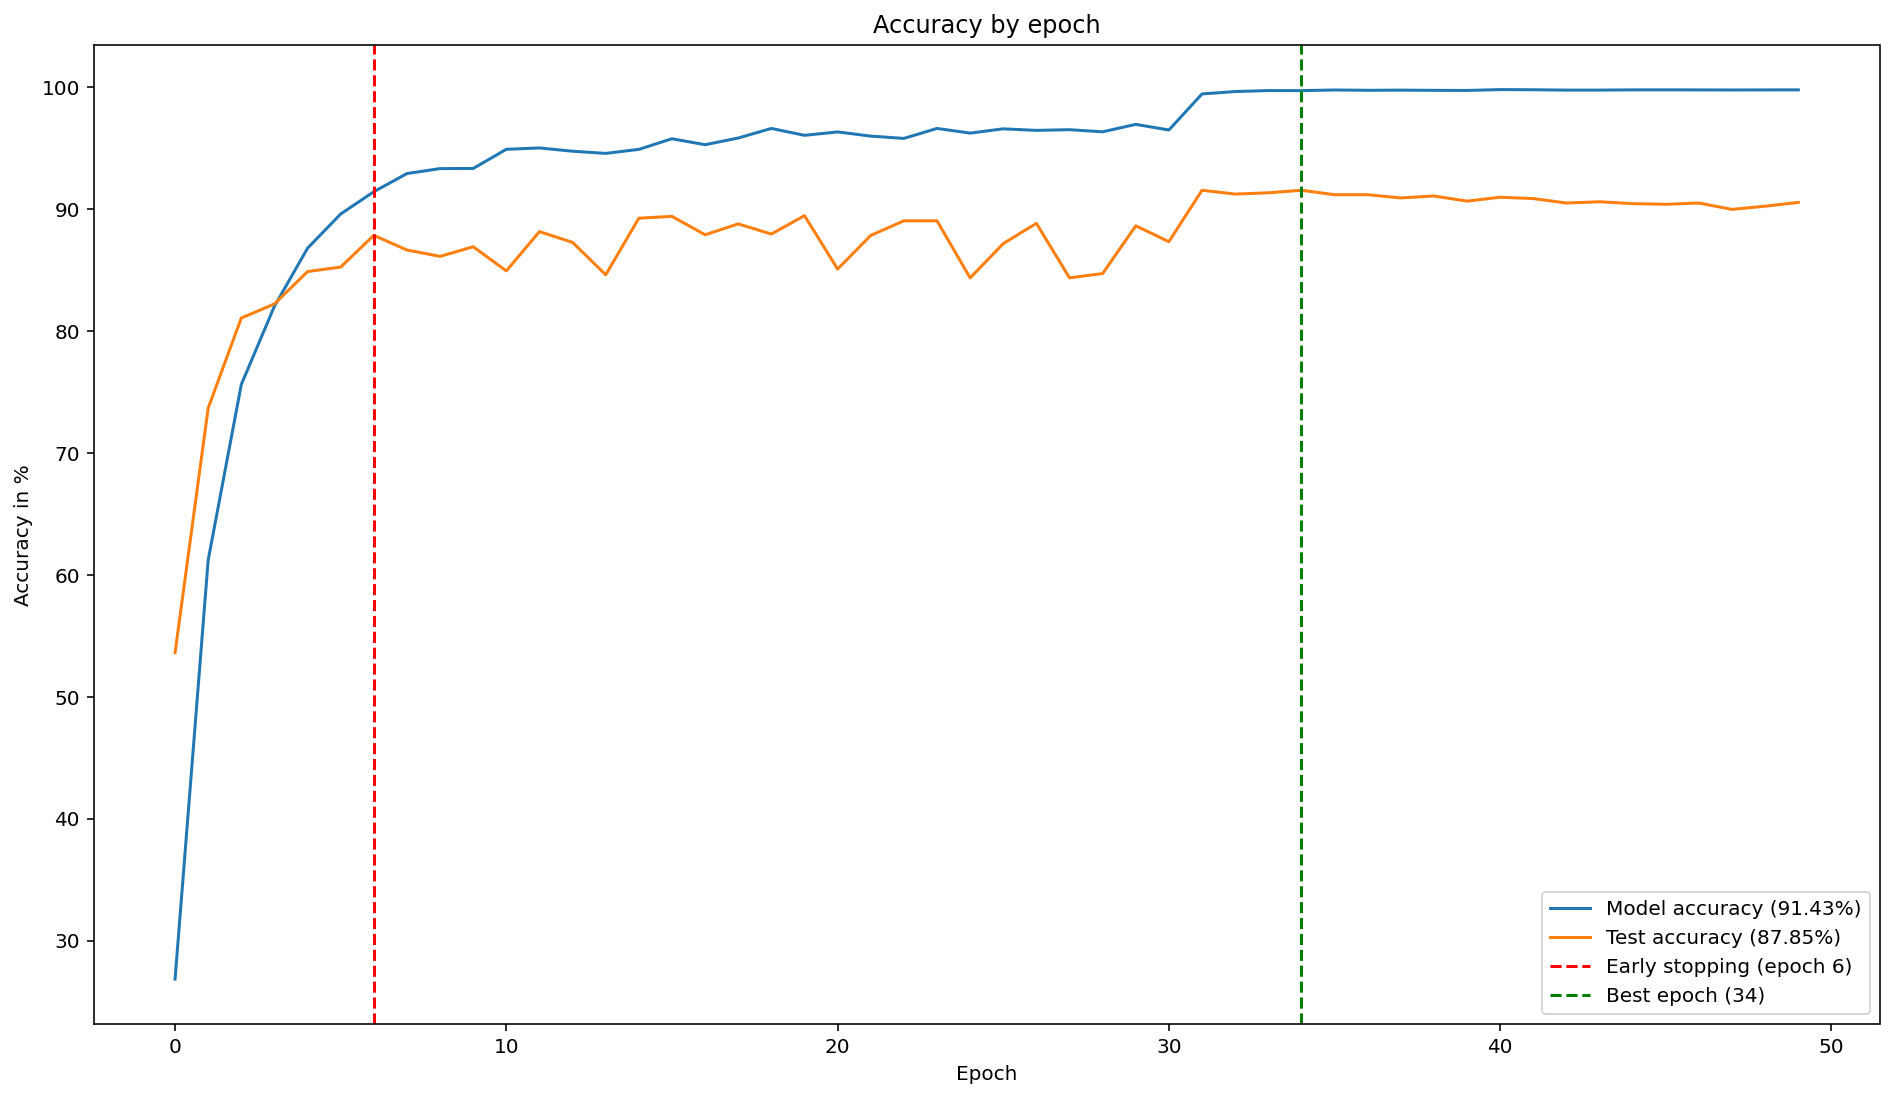

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Accuracy by epoch")
ax.plot(np.array(accs) * 100, label=f"Model accuracy ({accs[manual_checkpoint or best_epoch] * 100:.2f}%)")
ax.plot(np.array(accs_test) * 100, label=f"Test accuracy ({accs_test[manual_checkpoint or best_epoch] * 100:.2f}%)")
if manual_checkpoint:
  ax.axvline(manual_checkpoint, linestyle="--", label=f"Early stopping (epoch {manual_checkpoint:d})", color="red")
ax.axvline(best_epoch, linestyle="--", label=f"Best epoch ({best_epoch:d})", color="green")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy in %")
fig.show()

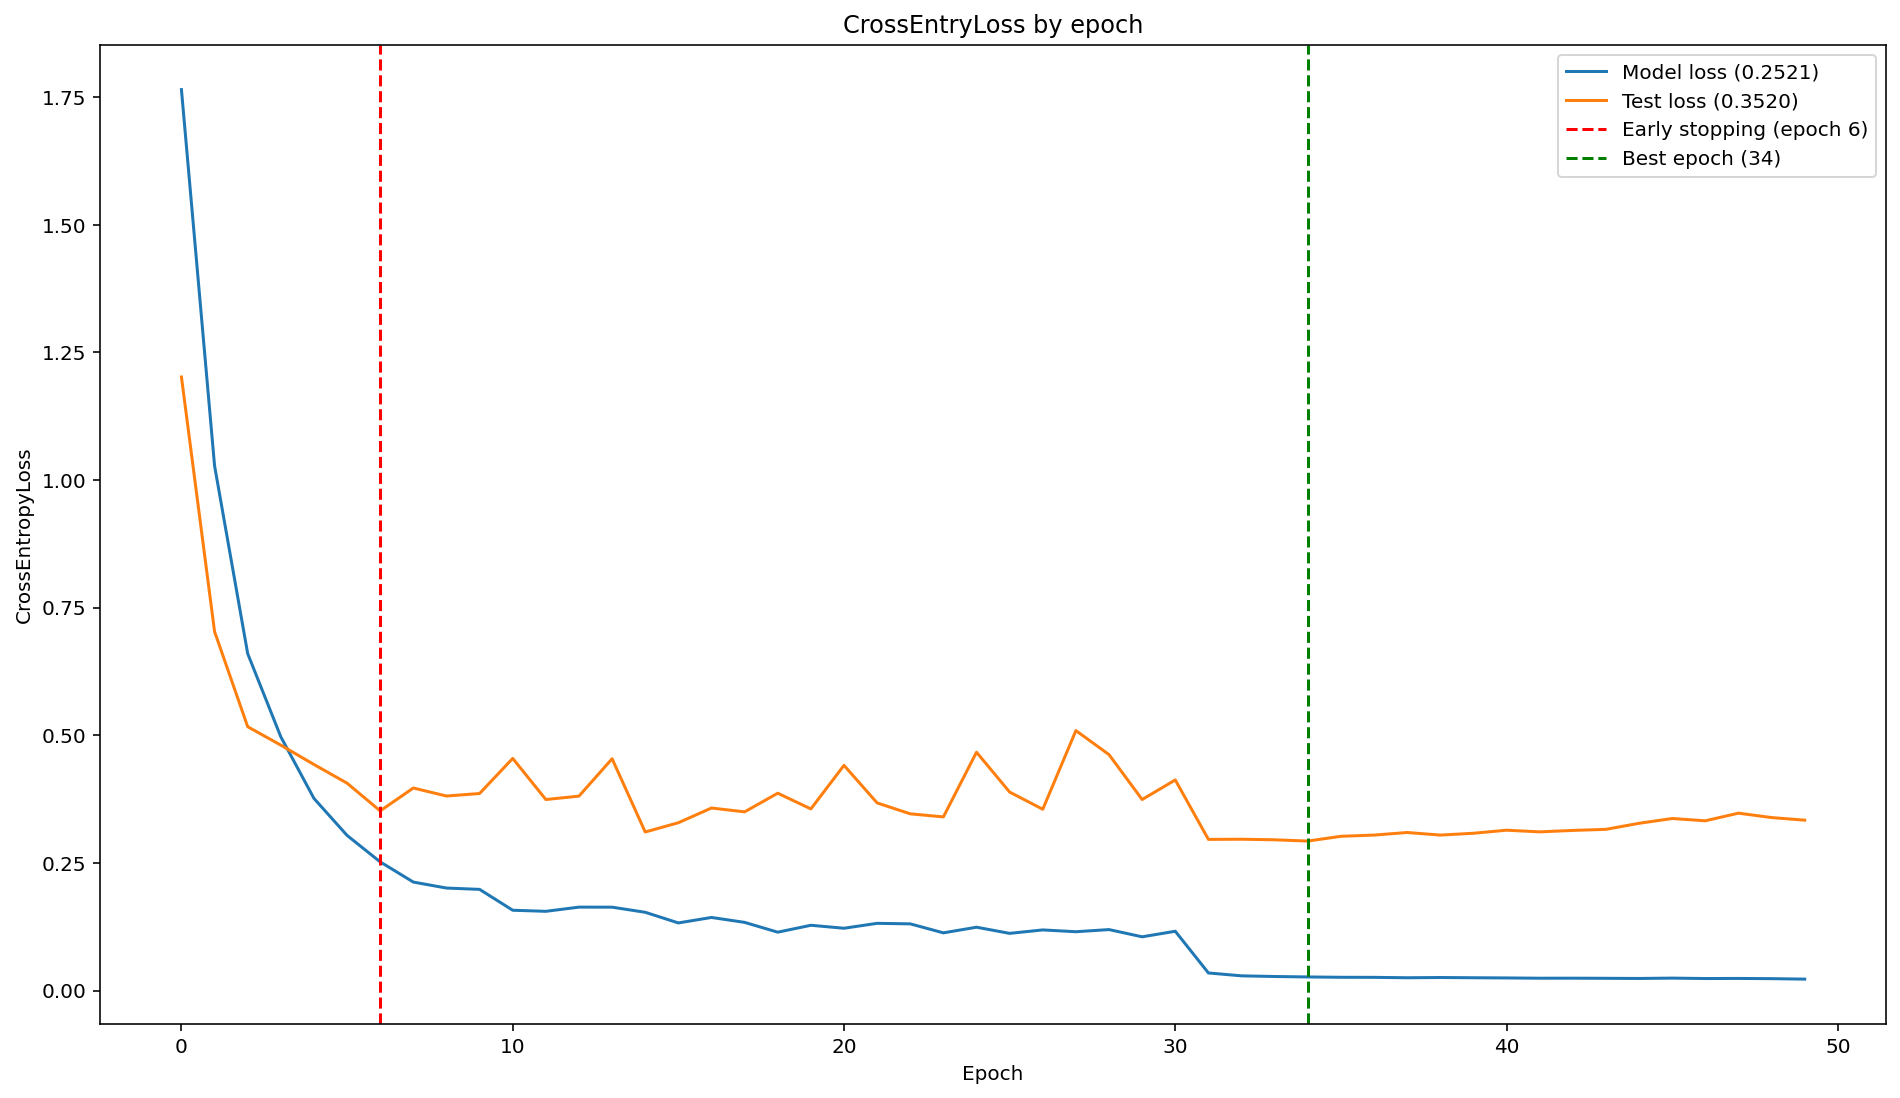

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("CrossEntryLoss by epoch")
ax.plot(losses, label=f"Model loss ({losses[manual_checkpoint or best_epoch]:.4f})")
ax.plot(losses_test, label=f"Test loss ({losses_test[manual_checkpoint or best_epoch]:.4f})")
if manual_checkpoint:
  ax.axvline(manual_checkpoint, linestyle="--", label=f"Early stopping (epoch {manual_checkpoint:d})", color="red")
ax.axvline(best_epoch, linestyle="--", label=f"Best epoch ({best_epoch})", color="green")
ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("CrossEntropyLoss")
fig.show()

# Evaluation

In [ ]:
emotions = [
  "neutral", 
  "happy", 
  "sad",
  "angry", 
  "fearful",
  "disgusted", 
  "surprised", 
]

In [ ]:
# Load the best model from disk (saved during training loop)
voice_emotion_cnn = VoiceEmotionCnn()
voice_emotion_cnn.load_state_dict(torch.load("/content/drive/MyDrive/CNN voice emotion recognition/saved_models/voice_emotion_cnn_resnet_parameters.pth"))
voice_emotion_cnn.to(DEVICE)
voice_emotion_cnn.eval();

In [ ]:
xb_all, yb_all = next(iter(test_dl))
for xb, yb in test_dl:
  xb_all = torch.cat((xb_all, xb), dim=0)
  yb_all = torch.cat((yb_all, yb), dim=0)
preds_all = torch.argmax(voice_emotion_cnn(xb_all), dim=1)

In [ ]:
print(classification_report(yb_all.cpu().numpy(), preds_all.cpu().numpy(), target_names=emotions))

              precision    recall  f1-score   support

     neutral       0.99      0.77      0.87       336
       happy       0.88      0.85      0.86       279
         sad       0.75      0.95      0.84       274
       angry       0.86      0.95      0.90       298
     fearful       0.92      0.80      0.86       278
   disgusted       0.91      0.85      0.88       203
   surprised       0.87      0.97      0.92       261

    accuracy                           0.87      1929
   macro avg       0.88      0.88      0.87      1929
weighted avg       0.88      0.87      0.87      1929



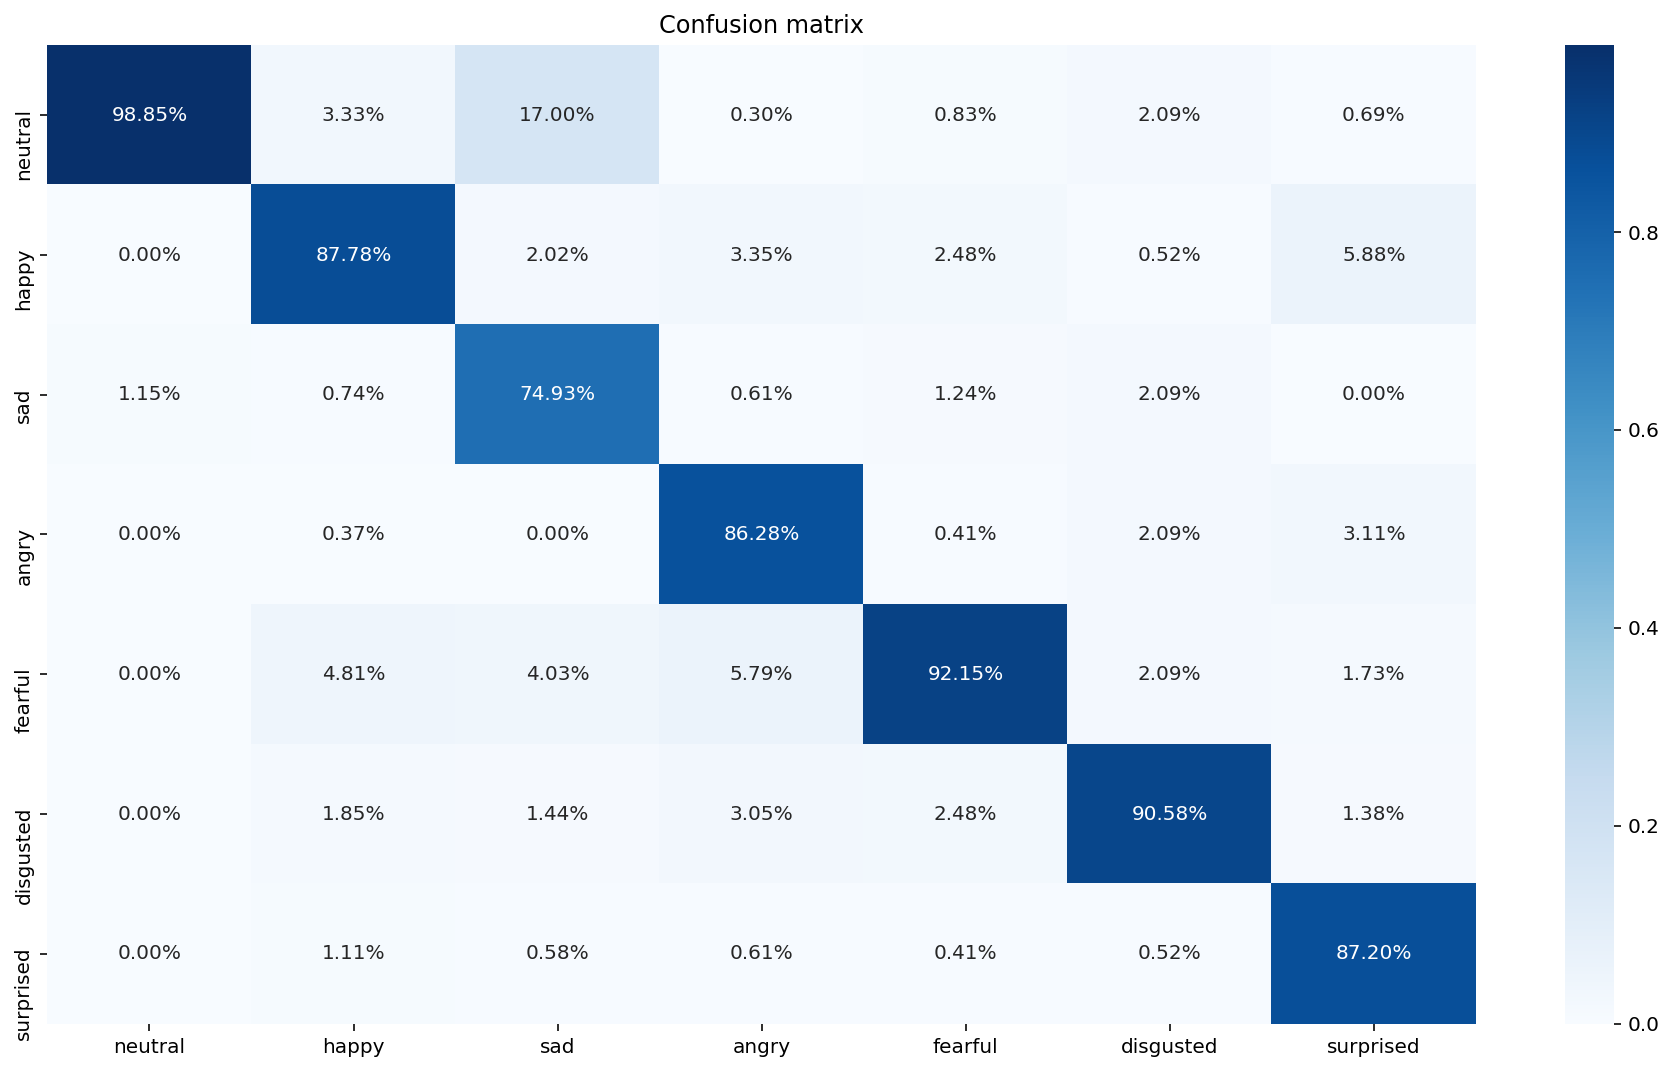

In [ ]:
fig, ax = plt.subplots(figsize=(16, 9))
ax.set_title("Confusion matrix")
cf_matrix = confusion_matrix(yb_all.cpu().numpy(), preds_all.cpu().numpy(), normalize="pred")
cf_matrix_df = pd.DataFrame(cf_matrix, emotions, emotions)
sns.heatmap(cf_matrix_df, annot=True, fmt=".2%", ax=ax, cmap='Blues');

# Model export to ONNX

In [ ]:
# For opset compatibility with ONNX.js check: https://github.com/microsoft/onnxjs/blob/master/docs/operators.md

dummy_input = xb.to(DEVICE)

torch.onnx.export(
    voice_emotion_cnn, 
    dummy_input, 
    "/content/drive/MyDrive/CNN voice emotion recognition/saved_models/voice_emotion_cnn_resnet.onnx", 
    export_params=True, 
    verbose=True,
    opset_version=13,
    do_constant_folding=True,
    input_names = ['input'],
    output_names = ['output'],
    dynamic_axes={
        'input' : {0 : 'batch_size'}, 
        'output' : {0 : 'batch_size'}
        }
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:45: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the

graph(%input : Float(*, 46305, strides=[46305, 1], requires_grad=0, device=cuda:0),
      %melspec_extractor.0.stft.conv_real.weight : Float(1025, 1, 1, 2048, strides=[2048, 2048, 2048, 1], requires_grad=0, device=cuda:0),
      %melspec_extractor.0.stft.conv_imag.weight : Float(1025, 1, 1, 2048, strides=[2048, 2048, 2048, 1], requires_grad=0, device=cuda:0),
      %melspec_extractor.1.melW : Float(1025, 128, strides=[1, 1025], requires_grad=0, device=cuda:0),
      %resnet18.fc.1.weight : Float(256, 512, strides=[512, 1], requires_grad=1, device=cuda:0),
      %resnet18.fc.1.bias : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %resnet18.fc.4.weight : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %resnet18.fc.4.bias : Float(256, strides=[1], requires_grad=1, device=cuda:0),
      %resnet18.fc.5.weight : Float(8, 256, strides=[256, 1], requires_grad=1, device=cuda:0),
      %resnet18.fc.5.bias : Float(8, strides=[1], requires_grad=1, device=cuda:0),
   

## Test export with Python ONNX runtime

In [ ]:
# Check if the model is valid
onnx_model = onnx.load("/content/drive/MyDrive/CNN voice emotion recognition/saved_models/voice_emotion_cnn_resnet.onnx")
onnx.checker.check_model(onnx_model)
print("IR_VERSION:", onnx_model.ir_version)

IR_VERSION: 6


In [ ]:
# Compare if the ONNX predictions are equal to the native PyTorch predictions from the Evaluation section
ort_session = onnxruntime.InferenceSession("/content/drive/MyDrive/CNN voice emotion recognition/saved_models/voice_emotion_cnn_resnet.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {"input": to_numpy(xb_all)}
ort_outs = ort_session.run(None, ort_inputs)

# compare ONNX Runtime and PyTorch results
np.testing.assert_allclose(to_numpy(preds_all), np.argmax(ort_outs[0], axis=1), rtol=0, atol=0)

print("Exported model has been tested with Python ONNXRuntime, and the result looks good!")

Exported model has been tested with Python ONNXRuntime, and the result looks good!
